In [46]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import pandas as pd

iris = np.genfromtxt('iris.txt')

######## DO NOT MODIFY THIS FUNCTION ########
def draw_rand_label(x, label_list):

    seed = abs(np.sum(x))
    while seed < 1:
        seed = 10 * seed
    seed = int(1000000 * seed)
    np.random.seed(seed)
    return np.random.choice(label_list)
#############################################
class Q1:
    #Pour toutes les fonctions de Q1, on veut ignorer la dernière col
    #On veut faire un tab contenant la moyenne de chaque cols => tab 1 x 4 (pcq 4 cols)
    def feature_means(self, iris):
        tabMoyCol = np.mean(iris[:, :-1], axis=0)
        return tabMoyCol

    #On veut faire une matrice de la covariance des attr (col) => matrice 4 x 4
    def empirical_covariance(self, iris):
        tabCov = np.cov(iris[:, :-1], rowvar=False)
        return tabCov

    #On veut la moyenne des vals dont dernière col = 1
    def feature_means_class_1(self, iris):
        #On prend toutes les valeurs de la classe 1
        tmp = iris[iris[:, -1] == 1]
        tabMoyClass1 = np.mean(tmp[:, :-1], axis=0)
        return tabMoyClass1

    def empirical_covariance_class_1(self, iris):
        tmp = iris[iris[:, -1] == 1]
        tabCovClass1 = np.cov(tmp[:, :-1], rowvar=False)
        return tabCovClass1
#Tests calss Q1
objQ1 = Q1()
print( objQ1.feature_means(iris) )
print( objQ1.empirical_covariance(iris) )
print( objQ1.feature_means_class_1(iris))
print( objQ1.empirical_covariance_class_1(iris)  )
class HardParzen:
    def __init__(self, h):
        self.h = h

    #On arrange les données pour def predict(self, test_data)
    def fit(self, train_inputs, train_labels):
        self.train_inputs = np.array(train_inputs)
        self.train_labels = np.array(train_labels).astype(int)
        #Param de la fonc draw_rand_label
        self.label_list = np.unique(train_labels)

    def predict(self, test_data):
        #array pour cumuler les prédictions
        tmp = []
        
        for pointTest in test_data:
            #1- On calc dist entre les pts d'entrainement et les pts de test
            distM = np.sum(np.abs(self.train_inputs - pointTest), axis=1)

            #2- On trouve les index associés aux voisins
            voisin = np.where(distM <= self.h)[0]
            
            #3- On fait la condition pour trouver le bon label
            #Si aucun voisin, on appel def draw_rand_label(x, label_list)
            if len(voisin) == 0:
                freq = draw_rand_label(pointTest, self.label_list)
            else:
                #Sinon, on va chercher les valeurs aux index voisin
                label = self.train_labels[voisin].astype(int)
                # et on prend celui qui revient le plus frequement
                freq = np.bincount(label).argmax()
            tmp.append(freq)
        
        #On change en numpy array
        predictions = np.array(tmp)
        return predictions
#TESTS class HardParzen
obj2 = HardParzen(1)
obj2.fit(iris[:, :-1], iris[:, -1])
print( obj2.predict(iris[:, :-1]) )

class SoftRBFParzen:
    def __init__(self, sigma):
        self.sigma  = sigma

    def fit(self, train_inputs, train_labels):
        self.train_inputs = np.array(train_inputs)
        self.train_labels = np.array(train_labels).astype(int)
        self.label_list = np.unique(train_labels)

    def predict(self, test_data):
        tmp = []
        
        for pointTest in test_data:
            #On calc la dist
            distM = np.sum(np.abs(self.train_inputs - pointTest), axis=1)
            #On calc le rbf
            rbf = np.exp( -distM**2 / (2*(self.sigma**2)) )
 
            #On fait un dictionnaire pour associer les labels à leur rbf
            dic = {label: np.sum(rbf[label == self.train_labels]) for label in self.label_list}
            
            #On sélectionne le label dans le dictionnaire dont le rbf est le plus grand
            tmp.append( max(dic, key=dic.get) )
            predictions = np.array(tmp)
        return predictions
#TESTS classe softParzen
obj3 = SoftRBFParzen(sigma=100)
obj3.fit(iris[:, :-1], iris[:, -1])
print( obj3.predict(iris[:, :-1]) )
def split_dataset(iris):
    #Le diviseur
    d = 5
    #Réponses possibles du modulo
    num = [0, 1, 2, 3, 4]
    #Conversion vers non numpy
    data = iris.tolist()
    #tmp pour stocker les résultats
    en012 =[]
    en3 =[]
    en4=[]

    #On passe à travers les données dans iris
    for elem in data:
        #On store l'index
        index = data.index(elem)
        #On compare l'index à tous les résultats possibles, puis on assignes les réponses aux bons endroits
        for i in num:
            if index % d == i:
                if i == 3:
                    en3.append(elem)
                if i == 4:
                    en4.append(elem)
                if i == 0 or i == 1 or i == 2:
                    en012.append(elem)
    
    #On converti en numpy array               
    ensembleEntrainement = np.array(en012)
    ensembleValidation = np.array(en3)
    ensembleTest = np.array(en4)
    return (ensembleEntrainement, ensembleValidation, ensembleTest)
#TESTS SPLIT_DATASET
split_dataset(iris)
class ErrorRate:
    #def __init__(Donnée entrainement sans derniere col, derniere col données entrainement, Données validation sans derniere col, derniere col données validation)
    def __init__(self, x_train, y_train, x_val, y_val):
        #x_train et x_val sont des matrices d'attributs à 4 colonnes
        #y_train et y_val sont des tableaux contenant les labels
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

    def hard_parzen(self, h):
        #On veut calc Parzen avec les données d'entrainement
        objHp = HardParzen(h)
        #On entraine algo sur x_train et y_train et l'évalue sur x_val
        objHp.fit(self.x_train, self.y_train)
        tabV = objHp.predict(self.x_val)
        
        """
        #Tx Erreur = Nb prédictions incorrectes / nb tot prédictions
        #Nb prédictions incorrectes = Σ prédictions qui != val réelle
        #Donc, Tx Erreur = Σ prédictions qui != val réelle / nb tot prédictions
        #   Ce qui est équivalent à la moyenne des prédictions
        #prédictions = hardParzen sur x_train et y_train avec x_val comme prédicteur sur les données d'entrainement
        #val réelle = y_val
        """
        #On calc le tx d'erreur => moy des données qui != les données de validation
        errorRate = np.mean(tabV != self.y_val)
        return errorRate

    def soft_parzen(self, sigma):
        #Même logique que pour def hard_parzen(self, h)
        objHp = SoftRBFParzen(sigma)
        objHp.fit(self.x_train, self.y_train)
        tabV = objHp.predict(self.x_val)
        errorRate = np.mean(tabV != self.y_val)
        return errorRate
def get_test_errors(iris):
    # h* est celle parmis choix_h qui minimise l'erreur de Hard Parzen sur l'ensemble de validation
    choix_h = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
    
    # σ* est le paramètre (parmis ceux proposés à la question 5) qui minimise l'erreur de Soft RBF Parzen sur l'ensemble de validation
    choix_sigma = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
    
    #1- On va chercher les ensembles avec split_dataset
    ensembles = split_dataset(iris)
    ensembleEntrainement = ensembles[0]
    ensembleValidation = ensembles[1]
    ensembleTest = ensembles[2]
    
    #2- On veut trouver h*
    #On fait un objet pour trouver les erreurs sur l'ensemble de validation
    objE = ErrorRate(ensembleEntrainement[:, :-1], ensembleEntrainement[:, -1], ensembleValidation[:, :-1], ensembleValidation[:, -1])
    #On fait un dictionnaire pour associer toutes les erreurs avec leur h
    dicH = {h : objE.hard_parzen(h) for h in choix_h}
    #On trouve le h avec la plus petite valeur
    h_etoile = min(dicH, key=dicH.get)
    
    #3- On veut trouver sigma*
    #Même logique qu'à l'étape 2
    dicS = {sigma : objE.soft_parzen(sigma) for sigma in choix_sigma}
    sigma_etoile = min(dicS, key=dicS.get)
    
    #4- On veut le tx d'erreur sur l'ensemble de test
    objE_etoile = ErrorRate(ensembleEntrainement[:, :-1], ensembleEntrainement[:, -1], ensembleTest[:, :-1], ensembleTest[:, -1])
    txE_h_etoile = objE_etoile.hard_parzen(h_etoile)
    txE_sigma_etoile = objE_etoile.soft_parzen(sigma_etoile)
    
    #On récupère les résultats dans un tab
    res = np.array([txE_h_etoile, txE_sigma_etoile])
    
    return res
get_test_errors(iris)

[5.84333333 3.05733333 3.758      1.19933333]
[[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]
[5.006 3.428 1.462 0.246]
[[0.12424898 0.09921633 0.0163551  0.01033061]
 [0.09921633 0.1436898  0.01169796 0.00929796]
 [0.0163551  0.01169796 0.03015918 0.00606939]
 [0.01033061 0.00929796 0.00606939 0.01110612]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3
 3 3]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2.

array([0.06666667, 0.03333333])

# Laurent Bouchard Rapport

### Résumé
Voici un résumé du fichier solution:
- "class Q1" : calcule moyenne et covariance.
- "class HardParzen" : calcule Parzen avec une fenêtre discrète de paramètre h en utilisant la distance de Manhattan.
- "class SoftRBFParzen" : calcule Parzen  en utilisant comme kernel une fonction à base radiale avec paramètre sigma.
- "split_dataset" : sépare le jeu de donnée iris en 3 ensembles(entrainement, validation et test)
- "class ErrorRate" : contient 2 fonctions qui calcule le taux d'erreur de "class HardParzen" et "class SoftRBFParzen" respectivement.
- "def get_test_errors(iris)": utilise les erreurs de classification sur l’ensemble de validation calculées par "class ErrorRate" pour sélectionner h* et σ*, puis qui calcule le taux d’erreur sur l’ensemble de test.


## Graphe de comparaison des erreurs de classification Parzen

### Informations
Nous voulons faire un graphe pour comparer les erreurs de classification de Parzen.
Il faut donc comparer les deux fonctions de "class ErrorRate".
- Courbe a : Représente les erreurs de classification de "HardParzen" sur l’ensemble de validation, après avoir été entraîné sur l’ensemble d’entraînement pour toutes les valeurs de h.
- Courbe b : Représente les erreurs de classification de "SoftRBFParzen" sur l’ensemble de validation, après avoir été entraîné sur l’ensemble d’entraînement pour toutes les valeurs de σ.

L’axe des abscisses représentera à la fois h et σ.  
L'axe des ordonnées représentera à la fois les erreurs de "HardParzen" et de de "SoftRBFParzen".


### Logique
Tout d'abbord, nous savons que la logique pour trouver la courbe a est la même que la courbe b.
Nous savons aussi toutes les valeurs de h et de σ :  
h ∈ {0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0}  
σ ∈ {0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0}  
Nous devons obtenir les ensembles d'entrainement et de validation à partir de "split_dataset".  
Nous savons que "split_dataset" retourne un tuple de forme (ensemble d'entrainement, ensemble de validation, ensemble de test).    
Nous voulons donc les indices 0 pour l'ensemble d'entrainement et 1 pour l'ensemble de validation.  
Nous pouvons maintenant évaluer "ErrorRate" sur l'ensemble d'entrainement et l'ensemble de validation.

### Calcul
```
#On fait tab des val h et sigma
hVal = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
sigmaVal = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]

#1- On récupère les données avec split_dataset
ens = split_dataset(iris)
#Entrainement
e = ens[0]
#Validation
v = ens[1]

#2- On veut "ErrorRate" de entrainement sur validation
#             (Données e, labels e, Données v, labels v)
er = ErrorRate(e[:, :-1], e[:, -1], v[:, :-1], v[:, -1])

#Courbe a
a = [er.hard_parzen(h) for h in hVal]
#Courbe b
b = [er.soft_parzen(sigma) for sigma in sigmaVal]

#3- On fait le graphique avec l'importation matplotlib.pyplot as plt
plt.plot(hVal, a, label='Hard Parzen Error')
plt.plot(sigmaVal, b, label='Soft Parzen Error')
plt.xlim(0, max(hVal))
plt.xlabel('h/σ')
plt.ylabel('Taux d\'Erreur')
plt.title('Comparaison des erreurs de classification Parzen')
plt.legend()
plt.grid(True)
plt.show()
```

### Graphe  
  
  

In [47]:
#On fait tab des val h et sigma
hVal = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
sigmaVal = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]

def graphe(hVal, sigmaVal):
    #1- On réccupère les données avec split_dataset
    ens = split_dataset(iris)
    e = ens[0]
    v = ens[1]

    #2- On veut ErrorRate de entrainement sur validation
    # Donc, ensembleEntrainement[:, :-1], ensembleEntrainement[:, -1]  => x_train, y_train (données, label)
    #       ensembleValidation[:, :-1]  , ensembleValidation[:, -1]    => x_val, y_val     (données, label)
    #On init Error rate avec les bonnes valeurs
    er = ErrorRate(e[:, :-1], e[:, -1], v[:, :-1], v[:, -1])
    a = [er.hard_parzen(h) for h in hVal]
    b = [er.soft_parzen(sigma) for sigma in sigmaVal]

    #3- On fait le graphique
    plt.plot(hVal, a, label='Hard Parzen Error')
    plt.plot(sigmaVal, b, label='Soft Parzen Error')
    plt.xlim(0, max(hVal))
    plt.xlabel('h/σ')
    plt.ylabel('Taux d\'Erreur')
    plt.title('Comparaison des erreurs de classification Parzen')
    plt.legend()
    plt.grid(True)
    plt.show()

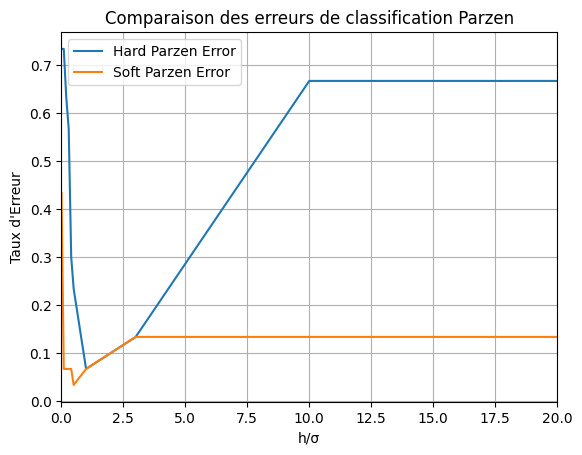

In [48]:
graphe(hVal, sigmaVal)

## Observations

En observant le graphe, nous remarquons que :
- Les courbes ont environ la même forme.  
Voulant dire que lorsque h/σ s'approche de 1.0, le taux d'erreur diminue drastiquement pour ensuite remonter et rester stable à 10.0.
- La fenêtre h de "HardParzen" est plus instable que la fonction à base radiale de "SoftRBFParzen".  
Le taux d'erreur fluctue beaucoup.  
"HardParzen" : passe de plus de 0.7 à moins de 0.1 et de 0.1 à plus de 0.6  
Versus  
"SoftRBFParzen" : passe d'un peu plus de 0.3 à moins que 0.1 et de 0.1 à plus de 0.1.


# Complexité emporelle
## Informations
Nous voudrions comparer la complexité de la fonction de prédiction de "HardParzen" avec celle de "SoftRBFParzen".  
Théoriquement, pour "HardParzen", chaque points doivent être comparés avec ceux contenus dans la fenêtre h.  
Alors que pour "SoftRBFParzen", il faut calculer l'influence de tous les points d'entrainement. 
Nous savons que les données en entrée sont les mêmes.  
Nous savons aussi que les calculs de la distance sont les mêmes.  
De plus, les deux fonctions itèrent sur le même ensemble d'entrainement.  
Donc, nous ne sommes pas obligé de prendre en compte la complexité de la distance et de la dimension des points.

## Logique "HardParzen"
Soit n la taille de l'ensemble d'entrainement, alors la fonction est au minimum O(n).  
Pour trouver les voisins, il faut passer à travers tous les points ce qui a une complexité de O(n).  
Ensuite, s'il n'y a pas de voisins, nous faisons appel à "def draw_rand_label(x, label_list)".  
Cette fonction sélectionne un élément aléatoire parmis "label_list".  
Soit l la grosseur de "label_list", la complexité de cette fonction est de O(l).  
finalement, On doit trouver le label parmis les voisins, alors on doit itérer sur les voisins.  
Soit v la grosseur des voisins, alors nous avons O(v).  
Nous avons deux choix de pire cas: O(n * v) ou O(n * l)  
Puisque je suis trop fatigué et que je n'arrête pas de me mélanger,   
 pour avoir un résultat plus satisfaisant on va dire que le pire cas est O(n * l).  
 (démarche mathématique sans failles)  
Ainsi, la complexité totale de la fonction pour "HardParzen" est : O(n * l).  

## Logique "SoftRBFParzen"
Soit n la taille de l'ensemble d'entrainement, alors la fonction est au minimum O(n).  
Pour calculer rbf, nous appliquons simplement une formule sur toutes les données ce qui a une complexité de O(n).  
Ensuite, nous devons itérer à travers "label_list" pour trouver le label dont la valeur est le maximum.  
La complexité totale de la fonction pour "SoftRBFParzen" est : O(n * l).  

## Évolution face au changement de h et σ
Théoriquement, on remarque que la complexité est environ la même.  
Cependant, il est toujours possible que je n'ai pas les facons les plus efficaces pour effectuer les calculs.  
Tout de même, plus le h sera petit, plus la complexité pour "HardParzen" sera petite, car la taille des voisins va diminuer.  
Pour "SoftRBFParzen", lorsque sigma augmente, plus le calcul avec l'exposant sera petit.  
Voici des exemples pour le temps de calcul :  

In [49]:
#Initier les fonctions
hS = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0, 30, 40, 50, 60]
ensemble = split_dataset(iris)
train = ensemble[0]
test = ensemble[2]
resultats = {
    "Nom de la Fonction": [],
    "Valeur de h/sigma" : [],
    "Temps Moyen (secondes)": []
}

for elem in hS:
    objH = HardParzen(elem)
    objH.fit(train[:, :-1], train[:, -1])
    # %timeit objH.predict(test[:, :-1])
    tempsH = timeit.timeit('objH.predict(test[:, :-1])', globals=globals(), number=10)
    resultats["Nom de la Fonction"].append("Hard Parzen")
    resultats["Valeur de h/sigma"].append(elem)
    resultats["Temps Moyen (secondes)"].append(tempsH)
    
    objS = SoftRBFParzen(elem)
    objS.fit(train[:, :-1], train[:, -1])
    #%timeit objS.predict(test[:, :-1])
    tempsS = timeit.timeit('objS.predict(test[:, :-1])', globals=globals(), number=10)
    resultats["Nom de la Fonction"].append("Soft Parzen")
    resultats["Valeur de h/sigma"].append(elem)
    resultats["Temps Moyen (secondes)"].append(tempsS)

df = pd.DataFrame(resultats)
df


,Nom de la Fonction,Valeur de h/sigma,Temps Moyen (secondes)
0,Hard Parzen,0.01,0.014276
1,Soft Parzen,0.01,0.006018
2,Hard Parzen,0.10,0.004960
3,Soft Parzen,0.10,0.005565
4,Hard Parzen,0.20,0.004016
5,Soft Parzen,0.20,0.005167
6,Hard Parzen,0.30,0.003535
7,Soft Parzen,0.30,0.005013
8,Hard Parzen,0.40,0.003083
9,Soft Parzen,0.40,0.005306


## Conclusion
Bref, on peut remarquer que plus le h/sigma augmente, plus le temps à tendance à diminuer pour les deux fonctions.